In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import torch
from torch import nn, optim
import numpy
import h5py
import os
import sys
import numpy as np
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
from data.synthetic_generator import syntheticMixture3D
from utils.training import train_mixture
from distributions.Watson_torch import Watson
from distributions.AngularCentralGauss_torch import AngularCentralGaussian as ACG
from models.MixtureModels.MixtureModel_torch import TorchMixtureModel

fmri_dataset = 'data/dataset/dataset_all_subjects_LEiDA.hdf5'

def get_param(model, show=True):
    para = model.get_model_param()
    
    if show:
        for p_k in para:
            print(p_k)
            print(para[p_k])
            print(10*'---')
    
    return para

# Mixture modelling - Synthectic data

### Generetate Synthetic 3D dataset

In [5]:
sig1 = torch.diag(torch.tensor([1, 1e-3, 1e-3]))
sig2 = torch.eye(3) + 0.9 * (torch.ones(3) - torch.eye(3))
sig3 = torch.diag(torch.tensor([1e-3, 1, 1])) \
       + 0.9 * torch.tensor([[0, 0, 0], [0, 0, 1], [0, 1, 0]])

SIGMAs = torch.stack([sig1, sig2, sig3], dim=0)
#print(SIGMAs, '\n-----------')

PIs = [0.6, 0.2, 0.2]

X, cluster_id = syntheticMixture3D(pi=PIs, Sigmas=SIGMAs, num_points=3000, as_array=False)

Simulate 3000 point from 3 of clusters


### Train on synthecic data

<IPython.core.display.Javascript object>


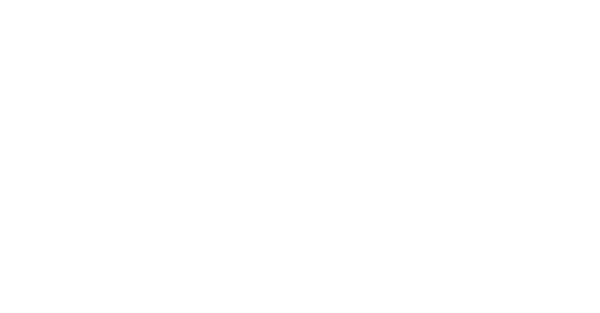

pi
tensor([0.2548, 0.4518, 0.2934])
------------------------------
mix_comp_0
{'mu': tensor([0.4323, 0.6788, 0.5936]), 'kappa': tensor([0.5222])}
------------------------------
mix_comp_1
{'mu': tensor([0.8803, 0.4454, 0.1632]), 'kappa': tensor([0.8993])}
------------------------------
mix_comp_2
{'mu': tensor([0.4913, 0.5728, 0.6561]), 'kappa': tensor([0.3075])}
------------------------------


100%|█████████████████████████████████████| 600/600 [00:01<00:00, 304.33it/s]

pi
tensor([0.3623, 0.6366, 0.0012])
------------------------------
mix_comp_0
{'mu': tensor([0.5229, 0.5878, 0.6173]), 'kappa': tensor([2.5979])}
------------------------------
mix_comp_1
{'mu': tensor([ 1.0000e+00, -2.0657e-04,  6.9069e-04]), 'kappa': tensor([76.1588])}
------------------------------
mix_comp_2
{'mu': tensor([0.0032, 0.7201, 0.6939]), 'kappa': tensor([43.4121])}
------------------------------


<IPython.core.display.Javascript object>


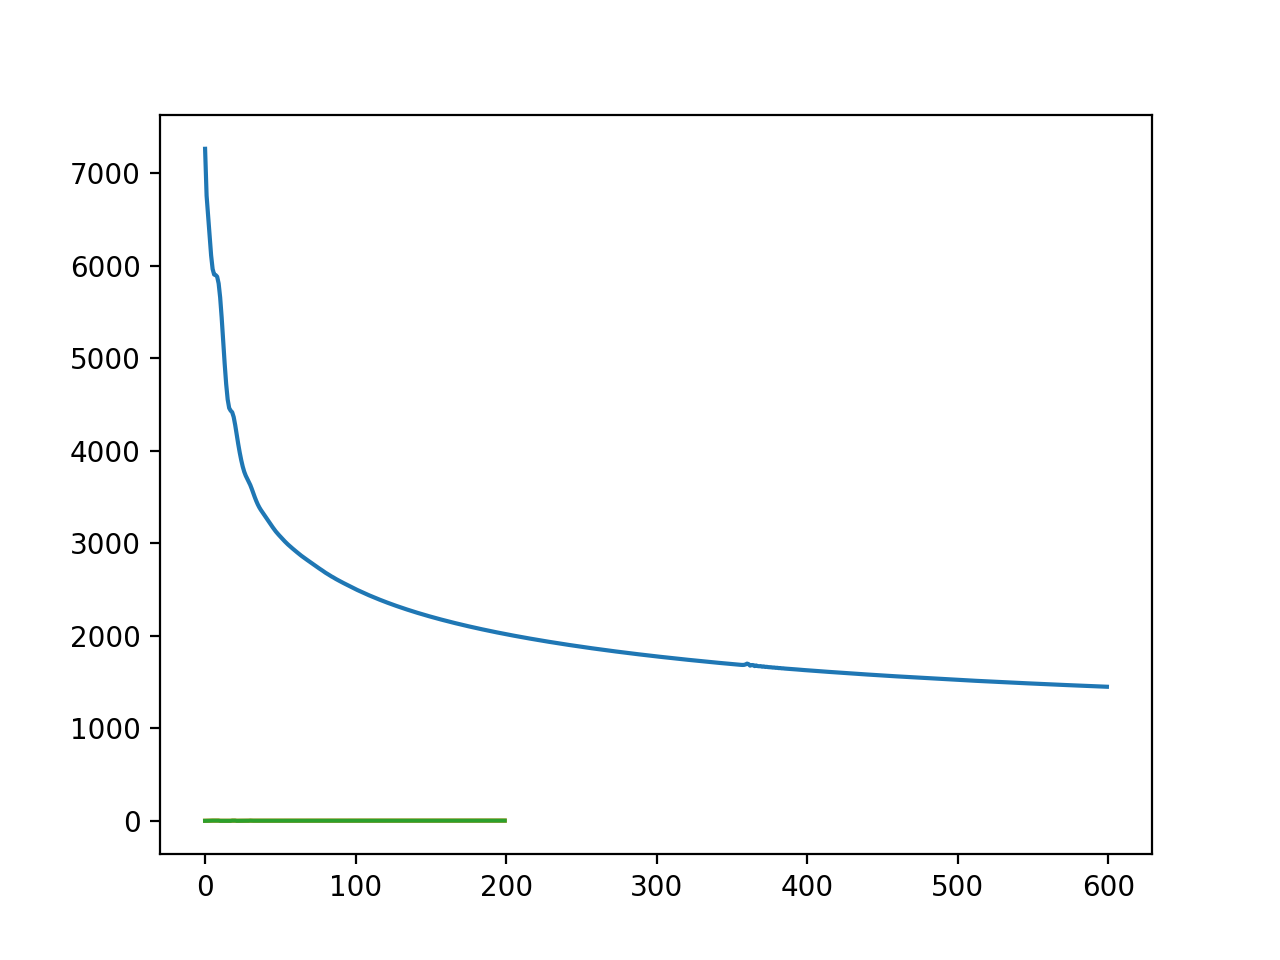

Min LL: 1448.7593994140625


In [116]:
plt.clf()
%matplotlib notebook
model_dist = Watson
model = TorchMixtureModel(model_dist, K=3, dist_dim=3)

_ = get_param(model)

Adam_optimizer = optim.Adam(model.parameters(), lr=0.4)

epoch_likelihood = train_mixture(model, data=X, optimizer=Adam_optimizer, num_epoch=600)

_ = get_param(model)

plt.plot(epoch_likelihood)
plt.show()
print(f'Min LL: {epoch_likelihood[-1]}')

### Fitting paramerter results

In [85]:
param = get_param(model)

pi
tensor([0.4505, 0.0006, 0.5490])
------------------------------
mix_comp_0
{'mu': tensor([0.5963, 0.5594, 0.5757]), 'kappa': tensor([2.4793])}
------------------------------
mix_comp_1
{'mu': tensor([0.0061, 0.6972, 0.7169]), 'kappa': tensor([47.6668])}
------------------------------
mix_comp_2
{'mu': tensor([ 1.0000e+00, -5.4645e-04, -1.6002e-03]), 'kappa': tensor([233.4122])}
------------------------------


In [86]:
## Synthectic as np array
synX, syn_cluster_id = np.array(X), np.array(cluster_id)

## Plot of Synthetic | Learned Mixture Clusters from Parameters | Watson $\mu$ directions

<IPython.core.display.Javascript object>


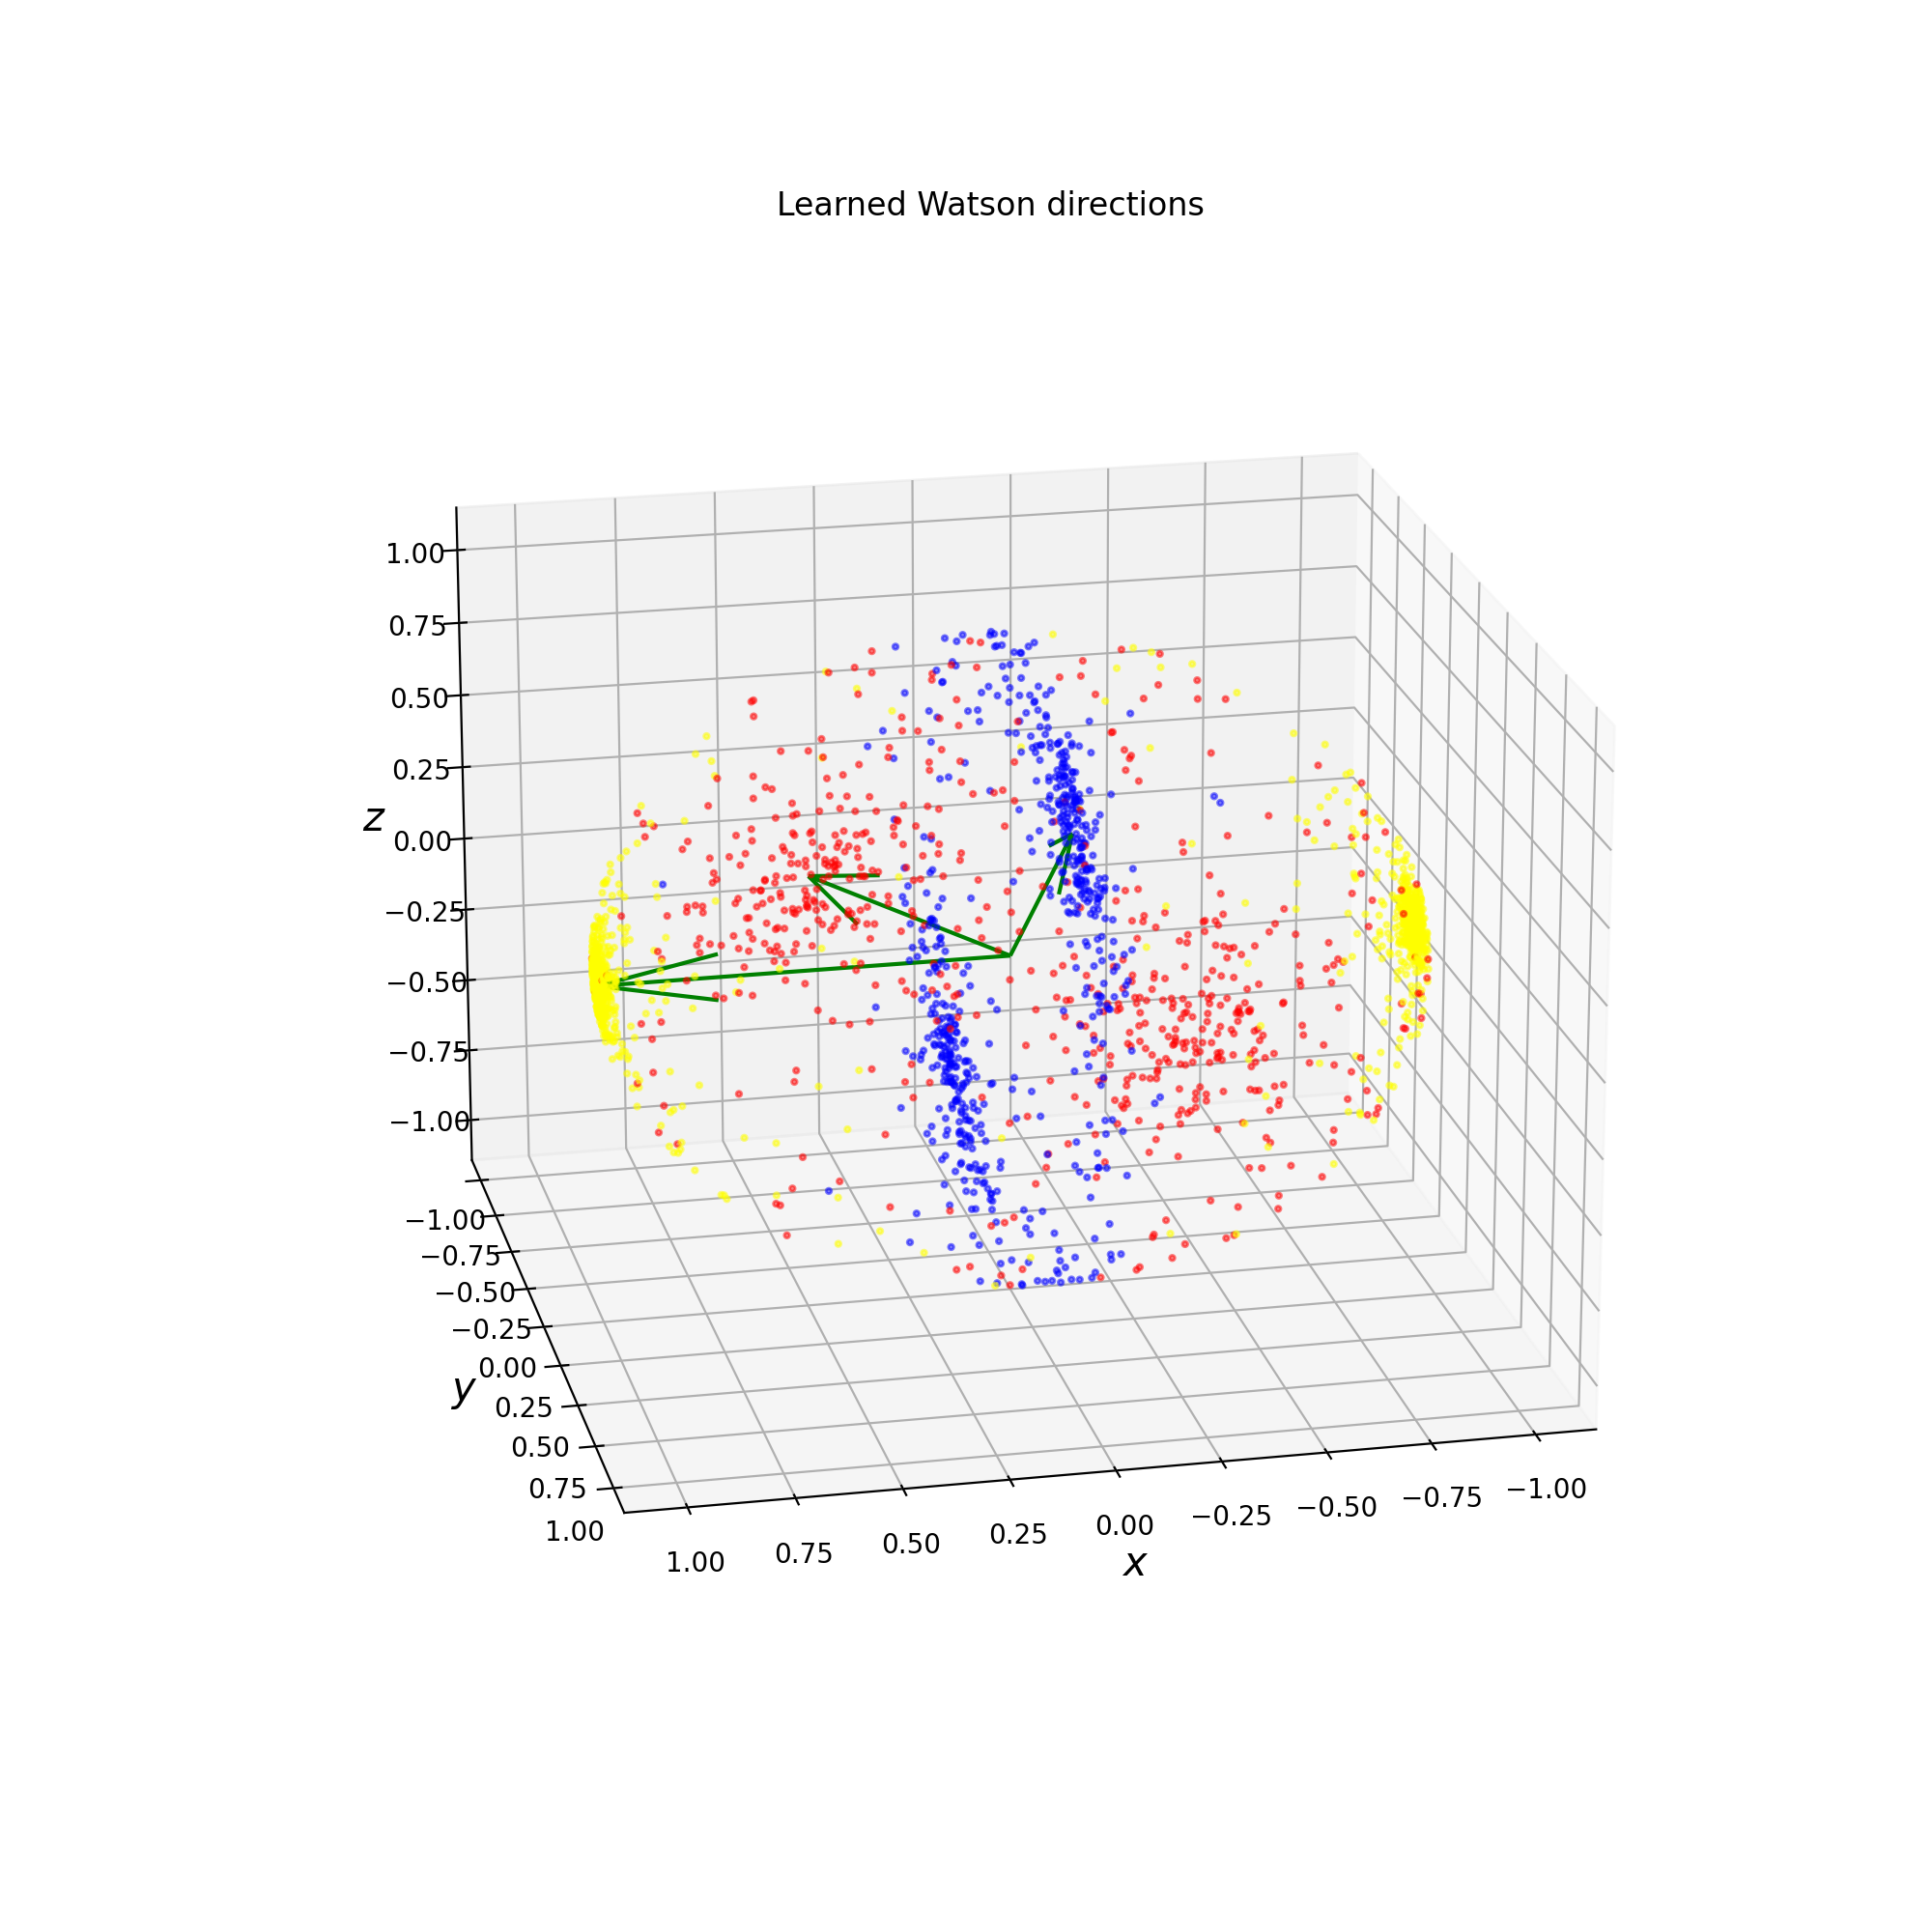

In [91]:
if model_dist == ACG:
    learned_sigma = torch.stack([param[f'mix_comp_{idx}'] for idx in range(model.K)])
    learned_pi = param['pi']
    LearnX, Learn_cluster_id = syntheticMixture3D(pi=learned_pi, Sigmas=learned_sigma, num_points=3000, as_array=True)
    
    fig = plt.figure(figsize=plt.figaspect(0.5))
    id_2_color = {0: 'cyan', 1: 'red', 2: 'blue'}

    # Synthetic
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    label_color = [id_2_color[id] for id in syn_cluster_id]
    ax.scatter(synX[:, 0], synX[:, 1], synX[:, 2], s=4, alpha=0.5, c=label_color)
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_zlabel('$z$', fontsize=15)
    ax.set_title('Synthetic')
    #Background
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.grid(False)

    u = np.linspace(0, 2 * np.pi, 20)
    v = np.linspace(0, np.pi, 20)

    x = .95 * np.outer(np.cos(u), np.sin(v))
    y = .95 * np.outer(np.sin(u), np.sin(v))
    z = .95 * np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_wireframe(x, y, z, color='grey', rstride=1, cstride=1, alpha=0.4, linewidth=0.5)
    ax.view_init(30, 135)

    # Learned
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    label_color = [id_2_color[id] for id in Learn_cluster_id]
    ax.scatter(LearnX[:, 0], LearnX[:, 1], LearnX[:, 2], s=4, alpha=0.5, c=label_color)
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_zlabel('$z$', fontsize=15)
    ax.set_title('Generated - Learned parameters')
    ax.view_init(30, 135)
    plt.show()


elif model_dist == Watson:
    Watson_comps = [param[f'mix_comp_{idx}'] for idx in range(model.K)]
    learned_pi = param['pi']
    
    
    fig = plt.figure(figsize=(10,10))
    id_2_color = {0: 'yellow', 1: 'red', 2: 'blue'}

#     # Synthetic
#     ax = fig.add_subplot(1, 2, 1, projection='3d')
#     label_color = [id_2_color[id] for id in syn_cluster_id]
#     ax.scatter(synX[:, 0], synX[:, 1], synX[:, 2], s=4, alpha=0.5, c=label_color)
#     ax.set_xlabel('$x$', fontsize=15)
#     ax.set_ylabel('$y$', fontsize=15)
#     ax.set_zlabel('$z$', fontsize=15)
#     ax.set_title('Synthetic')
    #Background
#     ax.xaxis.pane.fill = False
#     ax.yaxis.pane.fill = False
#     ax.zaxis.pane.fill = False
#     ax.xaxis.pane.set_edgecolor('w')
#     ax.yaxis.pane.set_edgecolor('w')
#     ax.zaxis.pane.set_edgecolor('w')
#     ax.grid(False)

#     u = np.linspace(0, 2 * np.pi, 20)
#     v = np.linspace(0, np.pi, 20)

#     x = .95 * np.outer(np.cos(u), np.sin(v))
#     y = .95 * np.outer(np.sin(u), np.sin(v))
#     z = .95 * np.outer(np.ones(np.size(u)), np.cos(v))
#     ax.plot_wireframe(x, y, z, color='grey', rstride=1, cstride=1, alpha=0.4, linewidth=0.5)
#     ax.view_init(30, 135)

    # Synthetic with Mean direction from watson
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    label_color = [id_2_color[id] for id in syn_cluster_id]
    ax.scatter(synX[:, 0], synX[:, 1], synX[:, 2], s=4, alpha=0.5, c=label_color)
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_zlabel('$z$', fontsize=15)
    ax.set_title('Learned Watson directions')
    # Watson Mu
    for w_param in Watson_comps:
        mu_vec = np.array(w_param['mu'])
        kappa_p = w_param['kappa']
        ax.quiver(0, 0, 0, *mu_vec, color = 'g')
    ax.view_init(30, 135)
    plt.show()
    

# Hidden Markov Model - Synthetic data

In [61]:
from data.synthetic_generator import syntheticMixture3D
from utils.training import train_mixture
from distributions.Watson_torch import Watson
from distributions.AngularCentralGauss_torch import AngularCentralGaussian as ACG
from models.MixtureModels.MixtureModel_torch import TorchMixtureModel
from models.HMM.HMM_torch import HiddenMarkovModel as HMM
from data.synthetic_generator import syntheticHMM
from utils.training import train_hmm

Simulate sequence of length 1000 from 3 hidden states


<IPython.core.display.Javascript object>


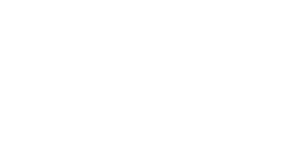

<IPython.core.display.Javascript object>


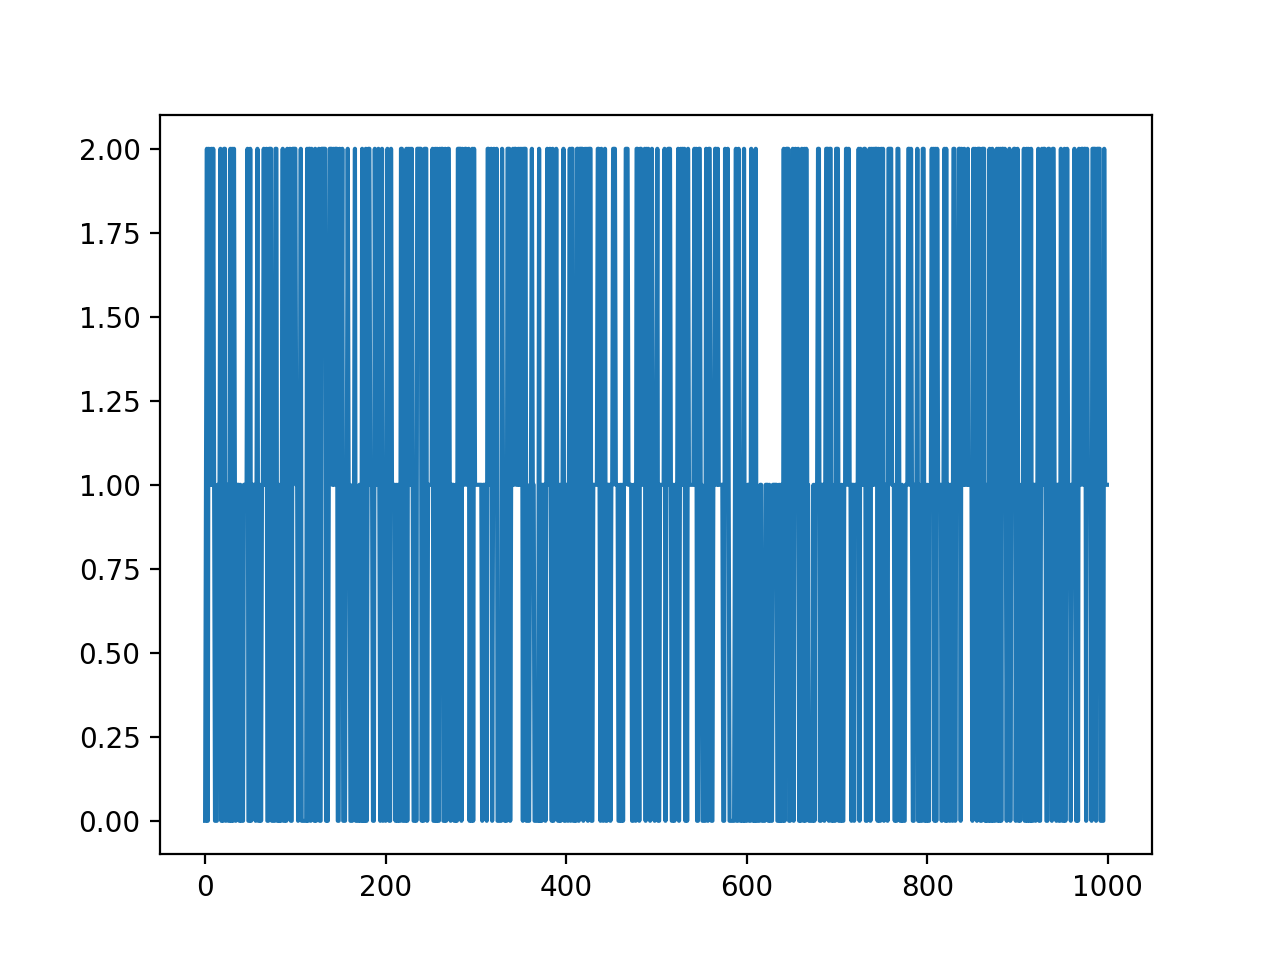

In [7]:
TRANSITION = torch.tensor([[0.4, 0.4, 0.2],
                          [0.2, 0.6, 0.2],
                          [0.4, 0.3, 0.3]])
PIs = [0.5, 0.2, 0.3]
X_emission, Z_seq = syntheticHMM(pi=PIs, Sigmas=SIGMAs, transition_matrix=TRANSITION, seq_len=1000)
plt.clf()
%matplotlib notebook
plt.plot(Z_seq)
plt.show()

### Training HMM on synthetic data

In [8]:
model_dist = ACG
model = HMM(num_states=3, observation_dim=3, emission_dist=model_dist)

_ = get_param(model)

priors
tensor([0.3805, 0.3349, 0.2847])
------------------------------
Transition_matrix
tensor([[0.2980, 0.3425, 0.3595],
        [0.3843, 0.2912, 0.3245],
        [0.3232, 0.3525, 0.3243]])
------------------------------
emission_model_0
tensor([[0.2336, 0.8821, 0.4424],
        [0.8821, 3.3629, 1.4981],
        [0.4424, 1.4981, 2.3504]])
------------------------------
emission_model_1
tensor([[ 3.2085e-03, -2.7110e-02, -2.0309e-02],
        [-2.7110e-02,  9.7107e-01,  1.8236e+00],
        [-2.0309e-02,  1.8236e+00,  4.0402e+00]])
------------------------------
emission_model_2
tensor([[ 2.3070e-02, -2.6715e-01, -2.6888e-03],
        [-2.6715e-01,  3.3787e+00,  5.8488e-01],
        [-2.6888e-03,  5.8488e-01,  1.6251e+00]])
------------------------------


In [78]:
test = X_emission[:3]
print(test)

model.emission_models_forward(test)

tensor([[ 0.9997,  0.0199, -0.0105],
        [ 0.0086,  0.6435,  0.7654],
        [ 0.0269,  0.3350,  0.9418]])


tensor([[ -2.9144,  -6.0582,  -6.3598],
        [ -1.1400,  -7.0391,  -6.2887],
        [ -3.2016, -11.0651, -11.6129]], grad_fn=<StackBackward0>)

In [79]:
model.emission_models[0].log_pdf(test)

tensor([-2.9144, -6.0582, -6.3598], grad_fn=<SubBackward0>)

In [80]:
_, A_inv = model.emission_models[0].compose_A()
print(A_inv)
print(test)

tensor([[ 8.0437,  4.7966, -7.4768],
        [ 4.7966,  9.6053, 17.1146],
        [-7.4768, 17.1146, 81.0113]], grad_fn=<MmBackward0>)
tensor([[ 0.9997,  0.0199, -0.0105],
        [ 0.0086,  0.6435,  0.7654],
        [ 0.0269,  0.3350,  0.9418]])


In [81]:
B = test @ A_inv
print(B)

tensor([[ 8.2155,  4.8075, -7.9825],
        [-2.5674, 19.3219, 72.9569],
        [-5.2183, 19.4661, 81.8309]], grad_fn=<MmBackward0>)


In [82]:
test @ A_inv @ test.T

tensor([[ 8.3928, -2.9460, -5.6863],
        [-2.9460, 68.2544, 75.1169],
        [-5.6863, 75.1169, 83.4516]], grad_fn=<MmBackward0>)

In [83]:
torch.diag(test @ A_inv @ test.T)

tensor([ 8.3928, 68.2544, 83.4516], grad_fn=<DiagBackward0>)

In [149]:
model.viterbi_2(X_emission.unsqueeze(dim=0))[0]

tensor([[[-5.6801, -5.8303, -5.7646],
         [-7.0652, -7.0901, -7.1751],
         [-4.3971, -4.5464, -4.5988]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-15.6328, -15.7830, -15.7173],
         [-13.4778, -13.5027, -13.5877],
         [-11.6882, -11.8374, -11.8899]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-25.4303, -25.5805, -25.5148],
         [-19.7358, -19.7608, -19.8458],
         [-19.1219, -19.2712, -19.3236]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-35.1012, -35.2514, -35.1857],
         [-26.8907, -26.9157, -27.0007],
         [-25.9680, -26.1172, -26.1697]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-41.2818, -41.4320, -41.3663],
         [-32.5424, -32.5673, -32.6523],
         [-31.7105, -31.8597, -31.9122]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-50.2813, -50.4314, -50.3658],
         [-37.2058, -37.2308, -37.3158],
         [-38.9688, -39.1180, -39.1705]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 

tensor([[[-1020.8268, -1020.9770, -1020.9114],
         [ -833.6055,  -833.6305,  -833.7155],
         [ -846.2650,  -846.4142,  -846.4667]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-1030.4485, -1030.5986, -1030.5330],
         [ -838.6823,  -838.7072,  -838.7922],
         [ -853.7259,  -853.8751,  -853.9276]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-1031.6036, -1031.7538, -1031.6881],
         [ -845.1516,  -845.1765,  -845.2615],
         [ -856.6410,  -856.7902,  -856.8427]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-1041.4806, -1041.6307, -1041.5651],
         [ -851.4061,  -851.4311,  -851.5161],
         [ -864.0732,  -864.2225,  -864.2749]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-1051.3682, -1051.5183, -1051.4526],
         [ -857.8749,  -857.8999,  -857.9849],
         [ -871.4498,  -871.5991,  -871.6515]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-1054.7280, -1054.8782, -1054.8125],
         [ -864.72

tensor([[[-2110.4392, -2110.5894, -2110.5237],
         [-1698.6913, -1698.7163, -1698.8013],
         [-1736.2472, -1736.3964, -1736.4489]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-2117.4983, -2117.6484, -2117.5828],
         [-1703.9534, -1703.9784, -1704.0634],
         [-1741.8274, -1741.9766, -1742.0291]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-2125.4473, -2125.5974, -2125.5317],
         [-1708.6353, -1708.6603, -1708.7452],
         [-1748.2698, -1748.4189, -1748.4714]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-2134.7185, -2134.8687, -2134.8030],
         [-1711.9264, -1711.9514, -1712.0364],
         [-1755.2715, -1755.4207, -1755.4731]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-2136.4590, -2136.6091, -2136.5435],
         [-1718.3715, -1718.3965, -1718.4814],
         [-1758.4679, -1758.6171, -1758.6696]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-2146.3708, -2146.5210, -2146.4553],
         [-1724.86

tensor([[[-3195.1150, -3195.2651, -3195.1995],
         [-2552.5591, -2552.5840, -2552.6692],
         [-2615.9934, -2616.1426, -2616.1951]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-3204.9697, -3205.1199, -3205.0542],
         [-2558.8813, -2558.9062, -2558.9915],
         [-2623.4160, -2623.5652, -2623.6177]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-3208.5645, -3208.7146, -3208.6489],
         [-2565.1509, -2565.1758, -2565.2610],
         [-2627.2190, -2627.3682, -2627.4207]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-3210.4985, -3210.6487, -3210.5830],
         [-2568.8257, -2568.8506, -2568.9358],
         [-2631.9668, -2632.1160, -2632.1685]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-3219.1650, -3219.3152, -3219.2495],
         [-2571.5242, -2571.5491, -2571.6343],
         [-2637.2358, -2637.3850, -2637.4375]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-3228.9089, -3229.0591, -3228.9934],
         [-2578.22

tensor([[[-4254.4766, -4254.6265, -4254.5610],
         [-3436.0840, -3436.1089, -3436.1941],
         [-3485.4346, -3485.5837, -3485.6362]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-4264.4307, -4264.5806, -4264.5151],
         [-3442.4797, -3442.5046, -3442.5898],
         [-3492.6877, -3492.8369, -3492.8894]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-4270.0708, -4270.2207, -4270.1553],
         [-3447.7529, -3447.7778, -3447.8630],
         [-3496.3770, -3496.5261, -3496.5786]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-4279.3340, -4279.4839, -4279.4185],
         [-3453.4724, -3453.4973, -3453.5825],
         [-3503.6719, -3503.8210, -3503.8735]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-4289.1182, -4289.2681, -4289.2026],
         [-3459.7385, -3459.7634, -3459.8486],
         [-3511.1016, -3511.2507, -3511.3032]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-4298.8784, -4299.0283, -4298.9629],
         [-3464.64

tensor([[[-5331.8188, -5331.9688, -5331.9033],
         [-4326.3716, -4326.3965, -4326.4814],
         [-4374.7769, -4374.9263, -4374.9785]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-5340.9946, -5341.1445, -5341.0791],
         [-4330.0146, -4330.0396, -4330.1245],
         [-4381.8936, -4382.0430, -4382.0952]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-5349.7148, -5349.8647, -5349.7993],
         [-4335.3882, -4335.4131, -4335.4980],
         [-4386.6201, -4386.7695, -4386.8218]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-5351.4492, -5351.5991, -5351.5337],
         [-4341.8115, -4341.8364, -4341.9214],
         [-4389.7090, -4389.8584, -4389.9106]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-5354.3691, -5354.5190, -5354.4536],
         [-4347.7061, -4347.7310, -4347.8159],
         [-4392.0859, -4392.2354, -4392.2876]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-5357.5366, -5357.6865, -5357.6211],
         [-4354.42

tensor([[[-6466.0913, -6466.2412, -6466.1758],
         [-5193.1562, -5193.1812, -5193.2661],
         [-5269.2144, -5269.3638, -5269.4160]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-6475.7710, -6475.9209, -6475.8555],
         [-5198.4395, -5198.4644, -5198.5493],
         [-5276.6919, -5276.8413, -5276.8936]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-6484.6230, -6484.7729, -6484.7075],
         [-5202.4810, -5202.5059, -5202.5908],
         [-5283.8130, -5283.9624, -5284.0146]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-6493.8896, -6494.0396, -6493.9741],
         [-5208.1436, -5208.1685, -5208.2534],
         [-5291.1191, -5291.2686, -5291.3208]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-6494.5176, -6494.6675, -6494.6021],
         [-5214.7070, -5214.7319, -5214.8169],
         [-5293.9595, -5294.1089, -5294.1611]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-6497.3765, -6497.5264, -6497.4609],
         [-5221.03

tensor([[[-7281.0078, -7281.1577, -7281.0923],
         [-5856.2529, -5856.2778, -5856.3628],
         [-5949.4189, -5949.5684, -5949.6206]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-7284.1895, -7284.3394, -7284.2739],
         [-5862.5566, -5862.5815, -5862.6665],
         [-5953.0132, -5953.1626, -5953.2148]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-7292.2197, -7292.3696, -7292.3042],
         [-5867.4116, -5867.4365, -5867.5215],
         [-5956.4268, -5956.5762, -5956.6284]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-7297.6777, -7297.8276, -7297.7622],
         [-5873.6323, -5873.6572, -5873.7422],
         [-5958.8965, -5959.0459, -5959.0981]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-7306.5894, -7306.7393, -7306.6738],
         [-5877.2856, -5877.3105, -5877.3955],
         [-5965.8560, -5966.0054, -5966.0576]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-7316.3198, -7316.4697, -7316.4043],
         [-5882.11

tensor([[[-8322.2236, -8322.3740, -8322.3076],
         [-6604.2378, -6604.2627, -6604.3477],
         [-6753.4614, -6753.6108, -6753.6631]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-8331.3936, -8331.5439, -8331.4775],
         [-6610.7817, -6610.8066, -6610.8916],
         [-6758.8828, -6759.0322, -6759.0845]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-8341.2109, -8341.3613, -8341.2949],
         [-6616.7900, -6616.8149, -6616.8999],
         [-6765.7476, -6765.8970, -6765.9492]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-8350.4766, -8350.6270, -8350.5605],
         [-6620.6699, -6620.6948, -6620.7798],
         [-6772.9668, -6773.1162, -6773.1685]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-8359.5410, -8359.6914, -8359.6250],
         [-6623.9194, -6623.9443, -6624.0293],
         [-6779.8755, -6780.0249, -6780.0771]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-8367.6738, -8367.8242, -8367.7578],
         [-6628.37

tensor([[[-9355.6855, -9355.8359, -9355.7695],
         [-7500.8472, -7500.8721, -7500.9570],
         [-7599.0371, -7599.1865, -7599.2388]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-9363.2500, -9363.4004, -9363.3340],
         [-7501.3237, -7501.3486, -7501.4336],
         [-7602.6479, -7602.7974, -7602.8496]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-9365.8047, -9365.9551, -9365.8887],
         [-7507.6924, -7507.7173, -7507.8022],
         [-7606.0459, -7606.1953, -7606.2476]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-9375.4004, -9375.5508, -9375.4844],
         [-7513.2441, -7513.2690, -7513.3540],
         [-7612.5220, -7612.6714, -7612.7236]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-9384.9434, -9385.0938, -9385.0273],
         [-7517.1587, -7517.1836, -7517.2686],
         [-7619.5796, -7619.7290, -7619.7812]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-9394.7969, -9394.9473, -9394.8809],
         [-7522.60

tensor([[[-10500.9131, -10501.0635, -10500.9971],
         [ -8371.7559,  -8371.7812,  -8371.8662],
         [ -8523.0781,  -8523.2275,  -8523.2803]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-10502.7002, -10502.8506, -10502.7842],
         [ -8378.2002,  -8378.2256,  -8378.3105],
         [ -8526.3027,  -8526.4521,  -8526.5049]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-10505.0957, -10505.2461, -10505.1797],
         [ -8384.6963,  -8384.7217,  -8384.8066],
         [ -8528.0352,  -8528.1846,  -8528.2373]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-10514.5439, -10514.6943, -10514.6279],
         [ -8388.7930,  -8388.8184,  -8388.9033],
         [ -8535.3203,  -8535.4697,  -8535.5225]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-10523.7285, -10523.8789, -10523.8125],
         [ -8392.6270,  -8392.6523,  -8392.7373],
         [ -8542.5068,  -8542.6562,  -8542.7090]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-10532.292

tensor([[[-11564.9980, -11565.1484, -11565.0820],
         [ -9292.3447,  -9292.3701,  -9292.4551],
         [ -9387.0312,  -9387.1807,  -9387.2334]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-11568.7695, -11568.9199, -11568.8535],
         [ -9298.5820,  -9298.6074,  -9298.6924],
         [ -9390.8643,  -9391.0137,  -9391.0664]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-11570.5137, -11570.6641, -11570.5977],
         [ -9305.2490,  -9305.2744,  -9305.3594],
         [ -9393.0908,  -9393.2402,  -9393.2930]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-11572.6650, -11572.8154, -11572.7490],
         [ -9311.6533,  -9311.6787,  -9311.7637],
         [ -9396.3672,  -9396.5166,  -9396.5693]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-11582.6016, -11582.7520, -11582.6855],
         [ -9318.1084,  -9318.1338,  -9318.2188],
         [ -9403.7051,  -9403.8545,  -9403.9072]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-11592.192

tensor([[[-12592.8926, -12593.0430, -12592.9766],
         [-10237.3848, -10237.4102, -10237.4951],
         [-10241.7812, -10241.9307, -10241.9834]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-12595.2393, -12595.3896, -12595.3232],
         [-10243.7529, -10243.7783, -10243.8633],
         [-10245.0322, -10245.1816, -10245.2344]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-12598.2432, -12598.3936, -12598.3271],
         [-10250.0625, -10250.0879, -10250.1729],
         [-10248.5098, -10248.6592, -10248.7119]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-12607.7129, -12607.8633, -12607.7969],
         [-10254.5615, -10254.5869, -10254.6719],
         [-10255.8906, -10256.0400, -10256.0928]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-12617.0254, -12617.1758, -12617.1094],
         [-10258.1738, -10258.1992, -10258.2842],
         [-10263.0225, -10263.1719, -10263.2246]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-12626.576

tensor([[[-13574.6523, -13574.8027, -13574.7363],
         [-11007.9756, -11008.0010, -11008.0859],
         [-11037.8164, -11037.9658, -11038.0186]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-13575.5547, -13575.7051, -13575.6387],
         [-11014.4961, -11014.5215, -11014.6064],
         [-11040.7891, -11040.9385, -11040.9912]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-13576.2471, -13576.3975, -13576.3311],
         [-11021.0195, -11021.0449, -11021.1299],
         [-11043.5381, -11043.6875, -11043.7402]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-13584.9189, -13585.0693, -13585.0029],
         [-11027.2666, -11027.2920, -11027.3770],
         [-11047.9600, -11048.1094, -11048.1621]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-13594.5459, -13594.6963, -13594.6299],
         [-11033.4326, -11033.4580, -11033.5430],
         [-11054.3623, -11054.5117, -11054.5645]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-13603.834

tensor([[[-14559.3535, -14559.5039, -14559.4375],
         [-11778.6064, -11778.6318, -11778.7168],
         [-11818.1680, -11818.3174, -11818.3701]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-14566.9414, -14567.0918, -14567.0254],
         [-11783.2197, -11783.2451, -11783.3301],
         [-11824.6465, -11824.7959, -11824.8486]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-14569.6943, -14569.8447, -14569.7783],
         [-11789.5820, -11789.6074, -11789.6924],
         [-11828.1602, -11828.3096, -11828.3623]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-14571.6836, -14571.8340, -14571.7676],
         [-11796.0000, -11796.0254, -11796.1104],
         [-11831.3926, -11831.5420, -11831.5947]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-14581.6123, -14581.7627, -14581.6963],
         [-11802.4971, -11802.5225, -11802.6074],
         [-11838.7266, -11838.8760, -11838.9287]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-14586.029

tensor([[0, 0, 0]])
tensor([[[-15599.6592, -15599.8096, -15599.7432],
         [-12657.0615, -12657.0869, -12657.1719],
         [-12687.5352, -12687.6846, -12687.7373]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-15605.7529, -15605.9033, -15605.8369],
         [-12662.6221, -12662.6475, -12662.7324],
         [-12692.1914, -12692.3408, -12692.3936]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-15614.8291, -15614.9795, -15614.9131],
         [-12665.4580, -12665.4834, -12665.5684],
         [-12698.9551, -12699.1045, -12699.1572]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-15623.6904, -15623.8408, -15623.7744],
         [-12670.7480, -12670.7734, -12670.8584],
         [-12706.0850, -12706.2344, -12706.2871]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-15625.7197, -15625.8701, -15625.8037],
         [-12677.1660, -12677.1914, -12677.2764],
         [-12709.3428, -12709.4922, -12709.5449]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])


tensor([[[-16609.6953, -16609.8457, -16609.7812],
         [-13473.3232, -13473.3486, -13473.4336],
         [-13504.6504, -13504.7998, -13504.8525]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-16612.0703, -16612.2207, -16612.1562],
         [-13479.7139, -13479.7393, -13479.8242],
         [-13508.0195, -13508.1689, -13508.2217]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-16612.7129, -16612.8633, -16612.7988],
         [-13486.2256, -13486.2510, -13486.3359],
         [-13510.6006, -13510.7500, -13510.8027]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-16622.4590, -16622.6094, -16622.5449],
         [-13491.1768, -13491.2021, -13491.2871],
         [-13517.6660, -13517.8154, -13517.8682]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-16630.7812, -16630.9316, -16630.8672],
         [-13495.4385, -13495.4639, -13495.5488],
         [-13524.2627, -13524.4121, -13524.4648]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-16632.337

tensor([[[-17534.1562, -17534.3066, -17534.2422],
         [-14263.0898, -14263.1152, -14263.2002],
         [-14270.2578, -14270.4072, -14270.4600]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-17544.0254, -17544.1758, -17544.1113],
         [-14268.7715, -14268.7969, -14268.8818],
         [-14277.7051, -14277.8545, -14277.9072]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-17553.8848, -17554.0352, -17553.9707],
         [-14275.1133, -14275.1387, -14275.2236],
         [-14285.1230, -14285.2725, -14285.3252]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-17554.7012, -17554.8516, -17554.7871],
         [-14281.6221, -14281.6475, -14281.7324],
         [-14287.9521, -14288.1016, -14288.1543]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-17557.2109, -17557.3613, -17557.2969],
         [-14287.8418, -14287.8672, -14287.9521],
         [-14290.8076, -14290.9570, -14291.0098]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-17566.902

tensor([[[-18700.0684, -18700.2188, -18700.1543],
         [-15197.6719, -15197.6973, -15197.7822],
         [-15229.4609, -15229.6104, -15229.6631]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-18709.6113, -18709.7617, -18709.6973],
         [-15202.0283, -15202.0537, -15202.1387],
         [-15236.7969, -15236.9463, -15236.9990]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-18718.7500, -18718.9004, -18718.8359],
         [-15205.7842, -15205.8096, -15205.8945],
         [-15243.9414, -15244.0908, -15244.1436]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-18727.9062, -18728.0566, -18727.9922],
         [-15210.7959, -15210.8213, -15210.9062],
         [-15251.2588, -15251.4082, -15251.4609]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-18735.7168, -18735.8672, -18735.8027],
         [-15215.5352, -15215.5605, -15215.6455],
         [-15257.4277, -15257.5771, -15257.6299]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-18744.843

tensor([[[-19751.6074, -19751.7578, -19751.6934],
         [-16038.9102, -16038.9355, -16039.0205],
         [-16071.2520, -16071.4014, -16071.4541]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-19754.2188, -19754.3691, -19754.3047],
         [-16045.2568, -16045.2822, -16045.3672],
         [-16074.5957, -16074.7451, -16074.7979]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-19764.1055, -19764.2559, -19764.1914],
         [-16051.5791, -16051.6045, -16051.6895],
         [-16082.0107, -16082.1602, -16082.2129]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-19773.6016, -19773.7520, -19773.6875],
         [-16055.6230, -16055.6484, -16055.7334],
         [-16089.2588, -16089.4082, -16089.4609]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-19783.4473, -19783.5977, -19783.5332],
         [-16061.1406, -16061.1660, -16061.2510],
         [-16096.7002, -16096.8496, -16096.9023]]], grad_fn=<AddBackward0>)
tensor([[0, 0, 0]])
tensor([[[-19792.693

IndexError: only integers, slices (`:`), ellipsis (`...`), None and long or byte Variables are valid indices (got float)

In [48]:
list(range(10-2,0,-1))

[8, 7, 6, 5, 4, 3, 2, 1]

In [43]:
list(range(1,10))

[1, 2, 3, 4, 5, 6, 7, 8, 9]

100%|████████████████████████████████| 100/100 [03:10<00:00,  1.91s/it]

priors
tensor([1.0000e+00, 1.6167e-09, 1.4016e-09])
------------------------------
Transition_matrix
tensor([[0.3686, 0.2815, 0.3499],
        [0.3686, 0.3334, 0.2980],
        [0.2884, 0.2835, 0.4281]])
------------------------------
emission_model_0
tensor([[91.6576, -7.5661, -3.8047],
        [-7.5661,  0.7197,  0.3148],
        [-3.8047,  0.3148,  0.2540]])
------------------------------
emission_model_1
tensor([[1.2688e-01, 8.9247e-03, 8.3745e-03],
        [8.9247e-03, 1.9822e+01, 4.1928e+01],
        [8.3745e-03, 4.1928e+01, 1.8932e+02]])
------------------------------
emission_model_2
tensor([[ 1.8536,  1.0185,  5.3491],
        [ 1.0185,  3.0529,  8.7955],
        [ 5.3491,  8.7955, 44.9454]])
------------------------------


<IPython.core.display.Javascript object>


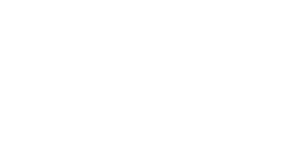

<IPython.core.display.Javascript object>


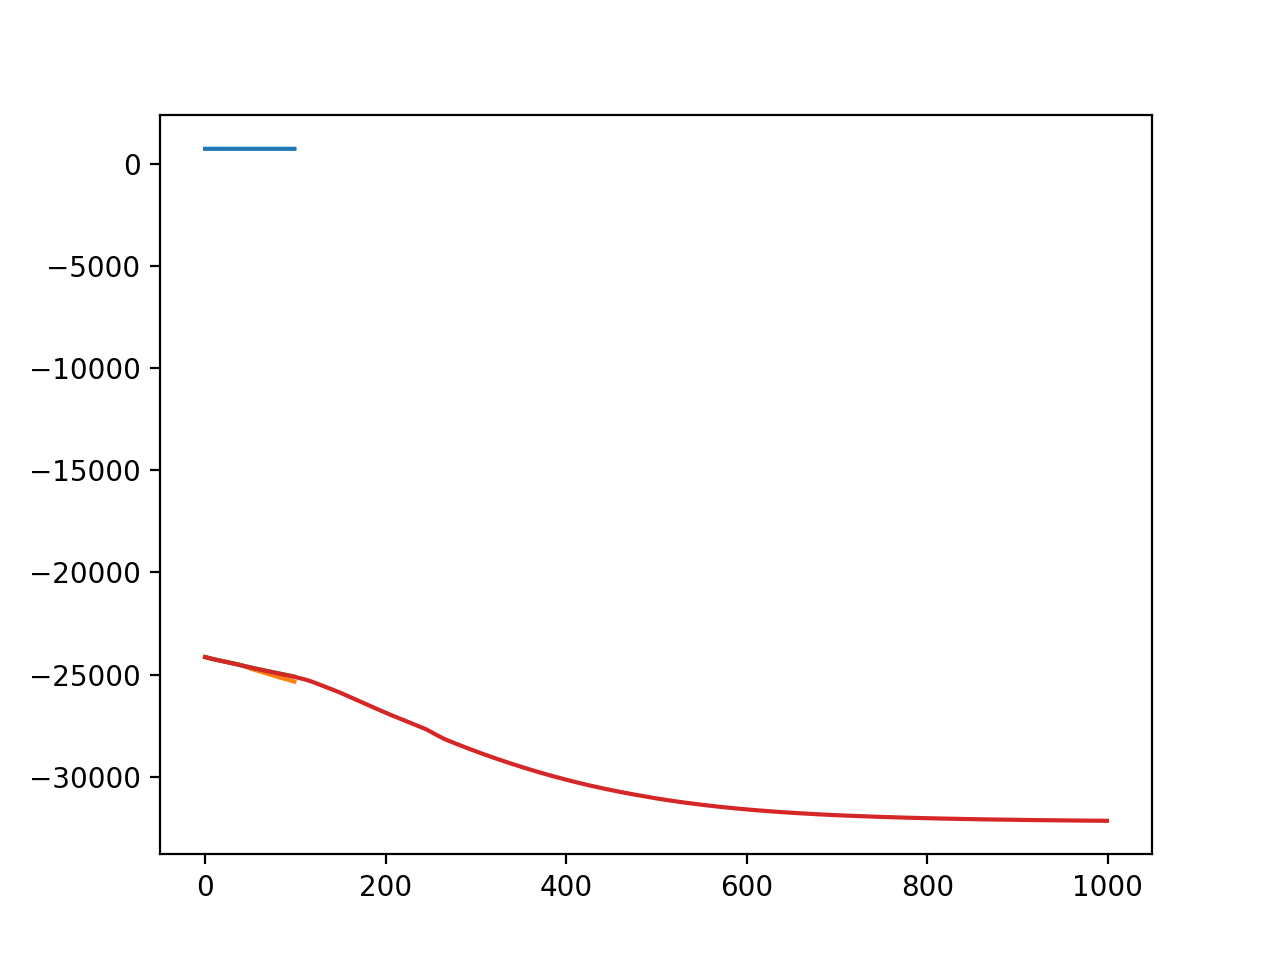

Min LL: 744.228515625
priors
tensor([1.0000e+00, 1.6167e-09, 1.4016e-09])
------------------------------
Transition_matrix
tensor([[0.3686, 0.2815, 0.3499],
        [0.3686, 0.3334, 0.2980],
        [0.2884, 0.2835, 0.4281]])
------------------------------
emission_model_0
tensor([[91.6576, -7.5661, -3.8047],
        [-7.5661,  0.7197,  0.3148],
        [-3.8047,  0.3148,  0.2540]])
------------------------------
emission_model_1
tensor([[1.2688e-01, 8.9247e-03, 8.3745e-03],
        [8.9247e-03, 1.9822e+01, 4.1928e+01],
        [8.3745e-03, 4.1928e+01, 1.8932e+02]])
------------------------------
emission_model_2
tensor([[ 1.8536,  1.0185,  5.3491],
        [ 1.0185,  3.0529,  8.7955],
        [ 5.3491,  8.7955, 44.9454]])
------------------------------


In [59]:
# add batch dim for HMM to X
Adam_optimizer = optim.Adam(model.parameters(), lr=0.01)
epoch_likelihood = train_hmm(model, data=X_emission.unsqueeze(dim=0), optimizer=Adam_optimizer, num_epoch=100)

_ = get_param(model)

plt.clf()
%matplotlib notebook
plt.plot(epoch_likelihood)
plt.show()
print(f'Min LL: {epoch_likelihood[-1]}')
_ = get_param(model)

In [62]:
seq, seq_prob = model.viterbi(X_emission.unsqueeze(dim=0))
seq

array([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [73]:
seq, seq_prob = model.viterbi_2(X_emission.unsqueeze(dim=0))

Delta:
tensor([[[  3.9635],
         [-28.6374],
         [-24.1459]]], grad_fn=<UnsqueezeBackward0>)
A:
tensor([[-0.9980, -1.2677, -1.0500],
        [-0.9980, -1.0985, -1.2107],
        [-1.2435, -1.2604, -0.8484]], grad_fn=<LogSoftmaxBackward0>)
Delta + A:
 tensor([[[  2.9655,   2.6958,   2.9135],
         [-29.6354, -29.7359, -29.8481],
         [-25.3894, -25.4063, -24.9943]]], grad_fn=<AddBackward0>)
max val and max index
tensor([[  2.9655, -29.6354, -24.9943]], grad_fn=<MaxBackward0>) tensor([[0, 0, 2]])
------------------------------
Delta:
tensor([[[ -2.6219],
         [-35.7881],
         [-24.8756]]], grad_fn=<UnsqueezeBackward0>)
A:
tensor([[-0.9980, -1.2677, -1.0500],
        [-0.9980, -1.0985, -1.2107],
        [-1.2435, -1.2604, -0.8484]], grad_fn=<LogSoftmaxBackward0>)
Delta + A:
 tensor([[[ -3.6200,  -3.8896,  -3.6719],
         [-36.7861, -36.8866, -36.9988],
         [-26.1191, -26.1360, -25.7240]]], grad_fn=<AddBackward0>)
max val and max index
tensor([[ -3.6200, -36

In [52]:
TRANSITION = torch.tensor([[0.4, 0.4, 0.2],
                          [0.2, 0.6, 0.2],
                          [0.4, 0.3, 0.3]])
param = get_param(model)
print(param['priors'])

priors
tensor([1.0000e+00, 2.1530e-07, 1.7480e-07])
------------------------------
Transition_matrix
tensor([[0.3686, 0.2815, 0.3499],
        [0.3686, 0.3334, 0.2980],
        [0.2884, 0.2836, 0.4281]])
------------------------------
emission_model_0
tensor([[80.9855, -6.6864, -3.3626],
        [-6.6864,  0.6360,  0.2782],
        [-3.3626,  0.2782,  0.2245]])
------------------------------
emission_model_1
tensor([[1.0146e-01, 7.1462e-03, 6.6828e-03],
        [7.1462e-03, 1.5845e+01, 3.3516e+01],
        [6.6828e-03, 3.3516e+01, 1.5134e+02]])
------------------------------
emission_model_2
tensor([[ 1.7843,  0.9803,  5.1488],
        [ 0.9803,  2.9382,  8.4653],
        [ 5.1488,  8.4653, 43.2592]])
------------------------------
tensor([1.0000e+00, 2.1530e-07, 1.7480e-07])


In [55]:
learned_sigma = torch.stack([param[f'emission_model_{idx}'] for idx in range(model.N)])
learned_pi = param['priors']

In [56]:
learned_pi

tensor([1.0000e+00, 2.1530e-07, 1.7480e-07])

In [39]:
param['Transition_matrix']

tensor([[0.3686, 0.2815, 0.3499],
        [0.3686, 0.3334, 0.2980],
        [0.2884, 0.2836, 0.4281]])

Simulate 3000 point from 3 of clusters


<IPython.core.display.Javascript object>


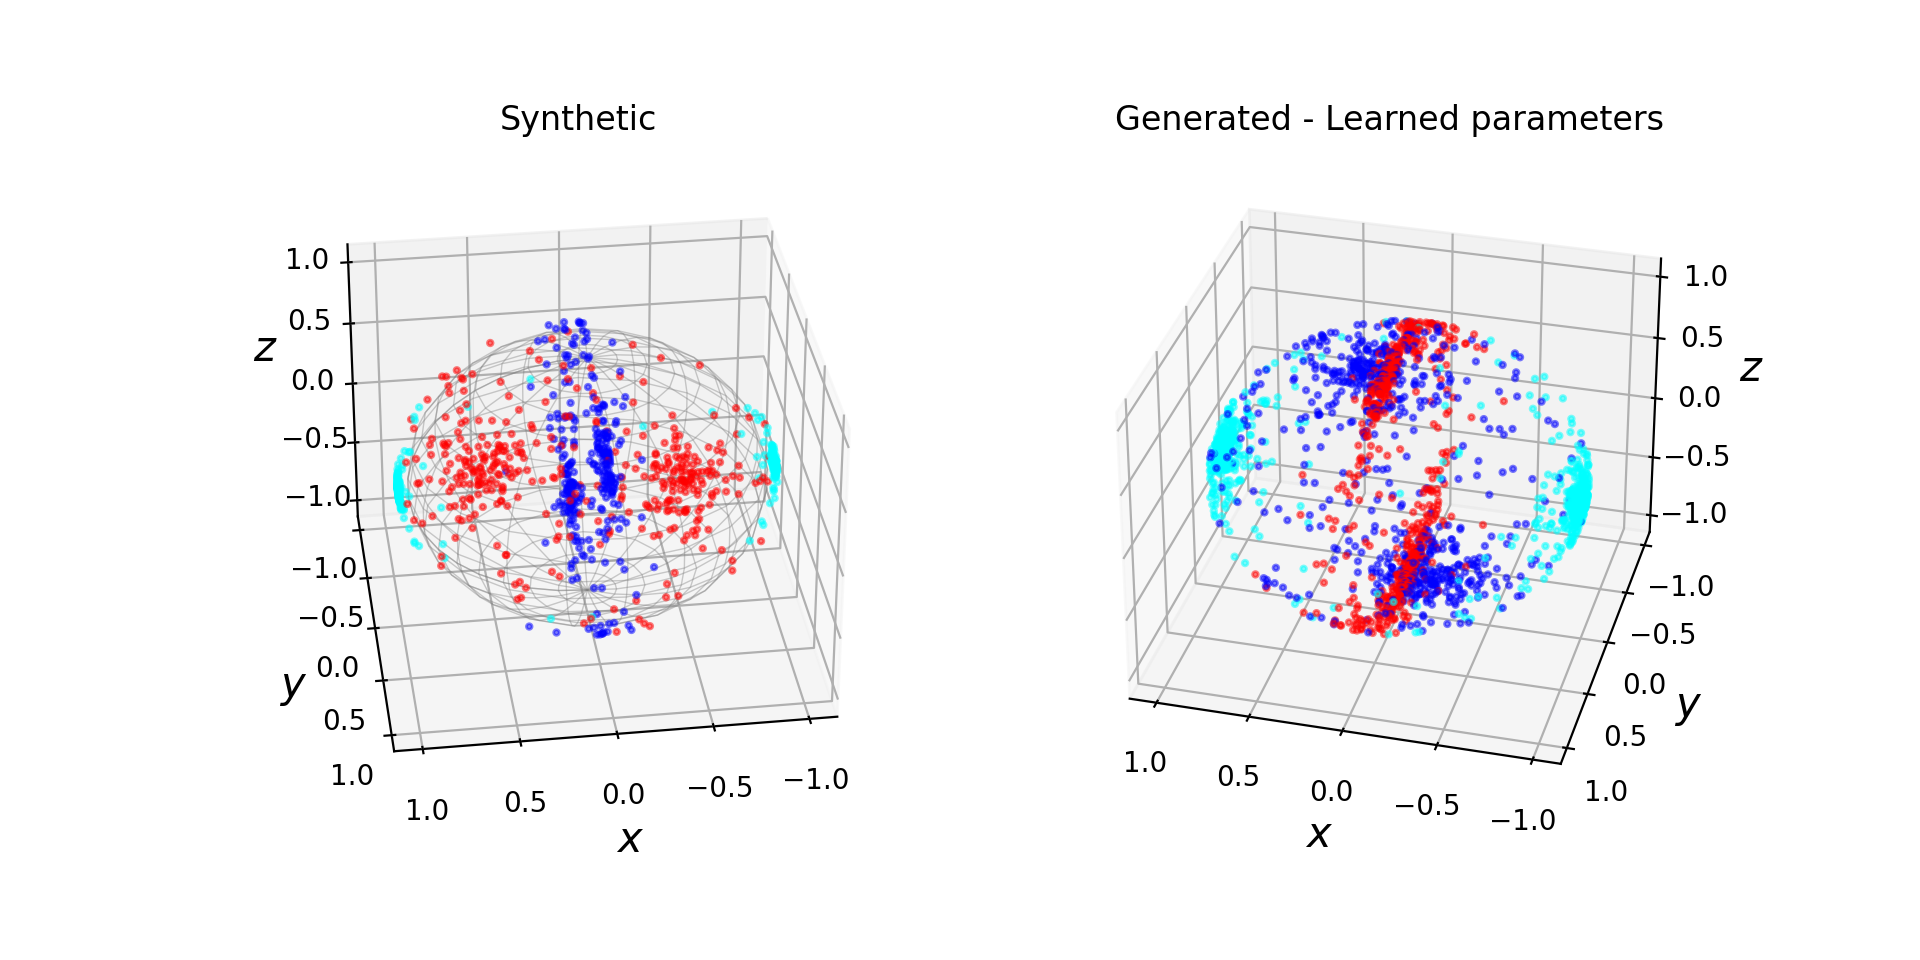

In [57]:
# softmax in syn generation
LearnX, Learn_cluster_id = syntheticMixture3D(pi=learned_pi, Sigmas=learned_sigma, num_points=3000, as_array=True)

fig = plt.figure(figsize=plt.figaspect(0.5))
id_2_color = {0: 'cyan', 1: 'red', 2: 'blue'}

# Synthetic
ax = fig.add_subplot(1, 2, 1, projection='3d')
label_color = [id_2_color[int(id)] for id in Z_seq]
ax.scatter(X_emission[:, 0], X_emission[:, 1], X_emission[:, 2], s=4, alpha=0.5, c=label_color)
ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
ax.set_zlabel('$z$', fontsize=15)
ax.set_title('Synthetic')


u = np.linspace(0, 2 * np.pi, 20)
v = np.linspace(0, np.pi, 20)

x = .95 * np.outer(np.cos(u), np.sin(v))
y = .95 * np.outer(np.sin(u), np.sin(v))
z = .95 * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_wireframe(x, y, z, color='grey', rstride=1, cstride=1, alpha=0.4, linewidth=0.5)
ax.view_init(30, 135)

# Learned
ax = fig.add_subplot(1, 2, 2, projection='3d')
label_color = [id_2_color[id] for id in Learn_cluster_id]
ax.scatter(LearnX[:, 0], LearnX[:, 1], LearnX[:, 2], s=4, alpha=0.5, c=label_color)
ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
ax.set_zlabel('$z$', fontsize=15)
ax.set_title('Generated - Learned parameters')
ax.view_init(30, 135)
plt.show()

# Mixture Model on FMRI data

In [108]:
import torch
from torch import nn, optim
import numpy
import h5py
import os
import sys
import numpy as np
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
sys.path.append(os.path.abspath(os.path.join('..')))
from data.synthetic_generator import syntheticMixture3D
from utils.training import train_mixture, train_mixture_subjects
from distributions.Watson_torch import Watson
from distributions.AngularCentralGauss_torch import AngularCentralGaussian as ACG
from models.MixtureModels.MixtureModel_torch import TorchMixtureModel
%matplotlib notebook
fmri_dataset = '../data/dataset/dataset_all_subjects_LEiDA.hdf5'

### Loading data

In [102]:
dataf = h5py.File(fmri_dataset, mode='r')

num_subjects = len(list(dataf.keys()))
seq_len = 330
obs_dim = 90
bold_data = torch.zeros(num_subjects,seq_len,obs_dim)

bold_mixture = torch.zeros(num_subjects*seq_len,obs_dim)

for idx, subject in enumerate(list(dataf.keys())):
    bold_data[idx] = torch.tensor(np.array(dataf[subject]))
    

print(bold_data.shape)

torch.Size([199, 330, 90])


100%|█| 100/100 [01:51<00:00,  1.12s/i


<IPython.core.display.Javascript object>


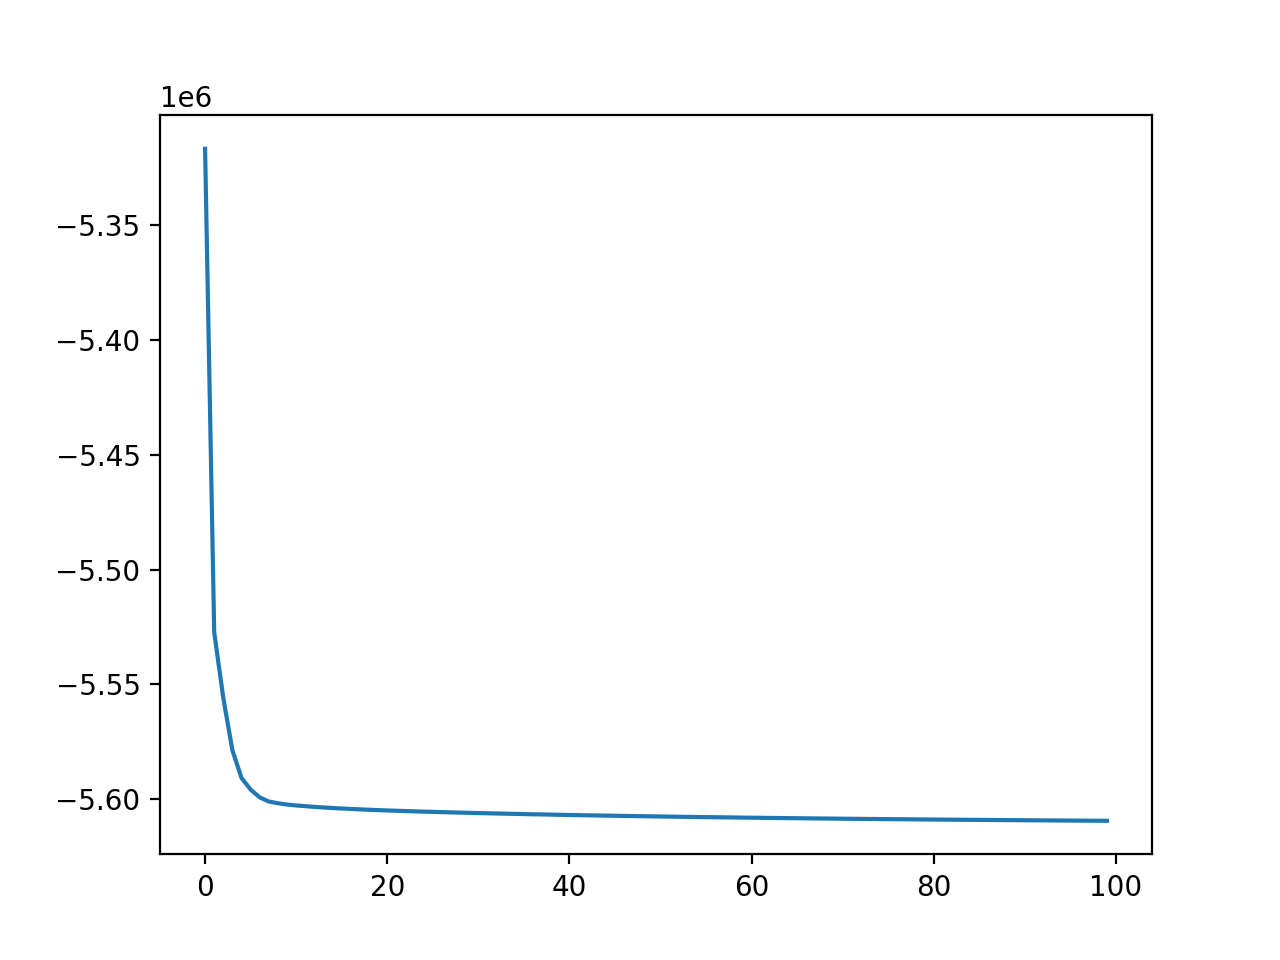

In [111]:
model_dist = Watson
model = TorchMixtureModel(model_dist, K=6, dist_dim=obs_dim)

#_ = get_param(model)

Adam_optimizer = optim.Adam(model.parameters(), lr=0.8)

epoch_likelihood = train_mixture_subjects(model, data=bold_data, optimizer=Adam_optimizer, num_epoch=100)

#_ = get_param(model)

plt.plot(epoch_likelihood)
plt.show()